# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an indication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GloBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GloBI (https://curiositydata.org/part1_globi_access/).


### For information: Invasive alien species of Union concern
|A|H|O|
|--|--|--|
|Acacia saligna|Herpestes javanicus|Pacifastacus leniusculus|
|Acridotheres tristis|Humulus scandens|Parthenium hysterophorus|
|Ailanthus altissima|Hydrocotyle ranunculoides|Pennisetum setaceum|
|Alopochen aegyptiaca|Impatiens glandulifera|Perccottus glenii|
|Alternanthera philoxeroides|Lagarosiphon major|Persicaria perfoliata|
|Andropogon virginicus|Lepomis gibbosus|Plotosus lineatus|
|Arthurdendyus triangulatus|Lespedeza cuneata|Procambarus clarkii|
|Asclepias syriaca|Lithobates catesbeianus|Procambarus fallax|
|Baccharis halimifolia|Ludwigia peploides|Procyon lotor|
|Cabomba caroliniana|Lygodium japonicum|Prosopis juliflora|
|Callosciurus erythraeus|Lysichiton americanus|Pseudorasbora parva|
|Cardiospermum grandiflorum|Microstegium vimineum|Pueraria montana|
|Cortaderia jubata|Muntiacus reevesi|Salvinia molesta|
|Corvus splendens|Myocastor coypus|Sciurus carolinensis|
|Ehrharta calycina|Myriophyllum aquaticum|Sciurus niger|
|Eichhornia crassipes|Myriophyllum heterophyllum|Tamias sibiricus|
|Elodea nuttallii|Nasua nasua|Threskiornis aethiopicus|
|Eriocheir sinensis|Nyctereutes procyonoides|Trachemys scripta|
|Gunnera tinctoria|Ondatra zibethicus|Triadica sebifera|
|Gymnocoronis spilanthoides|Orconectes limosus|Vespa velutina|
|Heracleum mantegazzianum|Orconectes virilis||
|Heracleum persicum|Oxyura jamaicensis||

In [1747]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [1748]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error
import pydot
import math

### Setting up some parameters

In [1749]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and birds
thresholdForOccNum = 5
# If you want to exclude an interaction add it here
#interactionsToExclude = "visitsFlowersOf" #If you're not intersted in pollinators this will remove most of them
#interactionsToExclude = "interactsWith"    #Many interactions in GloBI do not specify a specific interaction. You can get a cleaner netwot by excluding them
interactionsToExclude = ""

In [1750]:

## Define the country of interest
country  = 'Belgium'

## The occurrence cube has data for each year, but here we aggreagate years to get a more complete measure of occupancy.
## This parameter defines the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used#
# A script to create cube.db is here https://github.com/AgentschapPlantentuinMeise/occcube
database = r"..\..\data\cube.db" 

## A script to create globi.db is here https://github.com/AgentschapPlantentuinMeise/createGlobiDB
## Define the place to find the interaction data
globiDB = r"..\..\createGlobiDB\globi.db"

### Define the taxon for the notebook for which to find all interactions


In [1751]:
taxon=input()

Pueraria montana


In [1752]:
taxon = taxon.strip()

## Check to see if the taxon exits in GBIF

In [1753]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [1754]:
fullScientificName = match['scientificName']
print('The taxon to be studied is ' + fullScientificName)


The taxon to be studied is Pueraria montana (Lour.) Merr.


### Just for information take a look at the interactions that the taxon has

In [1755]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [1756]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE sourceTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
sourceInteractions = curGlobi.fetchall()

In [1757]:
sourceInteractions

[]

In [1758]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName, COUNT(interactionTypeName) from globi  WHERE targetTaxonSpeciesName = ? GROUP BY interactionTypeName;", (taxon,))
targetInteractions = curGlobi.fetchall()
targetInteractions

[('eats', 70), ('hasHost', 14), ('interactsWith', 91), ('pathogenOf', 3)]

## Get the primary interation data for the species in question

This is limited to the rank of species because otherwise the network can get very large with rather irrelivent higher taxa.
However, if no interactions are found at the species level it might be worth removing this restriction.

In [1759]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE targetTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [1760]:
curGlobi = connGlobi.cursor()
#curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
if interactionsToExclude == "":
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ?;", \
                 (taxon,))
else:
    curGlobi.execute("SELECT * from globi  WHERE sourceTaxonSpeciesName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [1761]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

178

In [1762]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [1763]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName', \
                                'sourceSexId', 'sourceSexName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName',\
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [1764]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [1765]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

41

In [1766]:
primaryInteractingTaxa = (primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName']).drop_duplicates())
len(primaryInteractingTaxa)

43

In [1767]:
primaryInteractingTaxa

0                          Cyrtolobus
1                 Megacopta cribraria
90                Pteropus dasymallus
98                  Astraptes anaphus
99                        Neptis soma
100                     Neptis sappho
101                    Neptis philyra
102                       Neptis nata
103                      Neptis hylas
104                            Rapala
105                          Nacaduba
106                 Lampides boeticus
107                           Jamides
108                     Curetis acuta
109               Celastrina argiolus
110                 Epargyreus clarus
112                Lycorma delicatula
113            Curetis acuta paracuta
114                Orosanga japonicus
118               Nyssiodes lefuarius
119               Spulerina dissotoma
121    Neolithocolletis hikomonticola
122               Hyloconis puerariae
133            Microthauma glycinella
134            Leucoptera puerariella
135             Anticarsia gemmatalis
140         

## A function to query the globi database

In [1768]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    if interactionsToExclude == "":
        cur.execute("SELECT * from globi  WHERE (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?);", \
                 (intaxon,intaxon,))
    else:
        cur.execute("SELECT * from globi where (targetTaxonSpeciesName = ? OR sourceTaxonSpeciesName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [1769]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [1770]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [1771]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [1772]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName',\
                                'sourceSexId', 'sourceSexName', 'interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName', 'targetSexId', 'targetSexName', \
                                'decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [1773]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [1774]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [1775]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonSpeciesName', 'sourceTaxonRank',
        'sourceTaxonFamilyName', 'interactionTypeName',
        'targetTaxonName','targetTaxonSpeciesName','targetTaxonRank', 'sourceCitation', 'sourceDOI',
        'sourceTaxonKingdomName','sourceTaxonKingdomId', 'targetTaxonKingdomName','targetTaxonKingdomId'                                        
        ]].dropna(subset=['targetTaxonSpeciesName','sourceTaxonSpeciesName'])

In [1776]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonSpeciesName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonSpeciesName'].drop_duplicates()

In [1777]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

813

In [1778]:
allInteractingTaxa.head()

0                        
1     Megacopta cribraria
90    Pteropus dasymallus
98      Astraptes anaphus
99            Neptis soma
dtype: object

In [1779]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
eats                1736
interactsWith        943
visitsFlowersOf      340
parasiteOf           228
hasHost              123
pathogenOf            59
preysOn               37
visits                31
hasVector             30
adjacentTo            16
pollinates            10
endoparasitoidOf       8
mutualistOf            2
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [1780]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [1781]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Citation for the GBIF Backbone Taxonomy

In [1782]:
from datetime import date
print("GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on ", date.today())

GBIF Secretariat (2019). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on  2020-07-24


### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [1783]:
taxaFound = {}
kingdom = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
        kingdom[name[1]] = GBIFName['kingdom']

    

Taxa from GLoBI, but not found in GBIF

Ficus variegata
Bat adenovirus FBV1
NPV
Spodoptera frugiperda rhabdovirus
Invertebrate iridovirus 22
Bonnetia comta
Quisqualis indica
Abrus precatorius


In [1784]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [1785]:
len(taxaFound)

813

In [1786]:
kingdom

{'Megacopta cribraria': 'Animalia',
 'Pteropus dasymallus': 'Animalia',
 'Astraptes anaphus': 'Animalia',
 'Neptis soma': 'Animalia',
 'Neptis sappho': 'Animalia',
 'Neptis philyra': 'Animalia',
 'Neptis nata': 'Animalia',
 'Neptis hylas': 'Animalia',
 'Lampides boeticus': 'Animalia',
 'Curetis acuta': 'Animalia',
 'Celastrina argiolus': 'Animalia',
 'Epargyreus clarus': 'Animalia',
 'Lycorma delicatula': 'Animalia',
 'Orosanga japonicus': 'Animalia',
 'Nyssiodes lefuarius': 'Animalia',
 'Spulerina dissotoma': 'Animalia',
 'Neolithocolletis hikomonticola': 'Animalia',
 'Hyloconis puerariae': 'Animalia',
 'Microthauma glycinella': 'Animalia',
 'Leucoptera puerariella': 'Animalia',
 'Anticarsia gemmatalis': 'Animalia',
 'Bocula marginata': 'Animalia',
 'Mocis undata': 'Animalia',
 'Spodoptera frugiperda': 'Animalia',
 'Jamides bochus': 'Animalia',
 'Cupido argiades': 'Animalia',
 'Euchrysops cnejus': 'Animalia',
 'Catochrysops strabo': 'Animalia',
 'Catochrysops panormus': 'Animalia',
 '

### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [1787]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [1788]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [1789]:
year

2000

In [1790]:
for GBIFtaxon in taxaFound.iterrows():
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    print(GBIFtaxon[0])
    if GBIFOccCount[0][0] > thresholdForOccNum and GBIFtaxon[0] != taxon: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))
    elif GBIFtaxon[0] == taxon:
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))


Megacopta cribraria
Pteropus dasymallus
Astraptes anaphus
Neptis soma
Neptis sappho
Neptis philyra
Neptis nata
Neptis hylas
Lampides boeticus
Lampides boeticus with key 1924713 occurs in 133 km squares.
Curetis acuta
Celastrina argiolus
Celastrina argiolus with key 1925918 occurs in 11950 km squares.
Epargyreus clarus
Lycorma delicatula
Orosanga japonicus
Nyssiodes lefuarius
Spulerina dissotoma
Neolithocolletis hikomonticola
Hyloconis puerariae
Microthauma glycinella
Leucoptera puerariella
Anticarsia gemmatalis
Bocula marginata
Mocis undata
Spodoptera frugiperda
Jamides bochus
Cupido argiades
Cupido argiades with key 4535140 occurs in 264 km squares.
Euchrysops cnejus
Catochrysops strabo
Catochrysops panormus
Rapala arata
Devosia yakushimensis
Kudzu mosaic virus
Pratylenchus coffeae
Kerria ruralis
Encarsiella boswelli
Trema orientalis
Melia azedarach
Psidium guajava
Diospyros egbert-walkeri
Ficus palmata
Ficus variegata
Ficus superba
Ficus septica
Ficus sarmentosa
Ficus tinctoria
Ficu

Lathyrus humilis
Lespedeza bicolor
Lathyrus vernus
Lathyrus vernus with key 5356704 occurs in 7 km squares.
Dalbergia sissoo
Vigna unguiculata
Canavalia ensiformis
Zelkova serrata
Zelkova serrata with key 2984532 occurs in 7 km squares.
Ulmus davidiana
Rhamnus davurica
Aphananthe aspera
Hibiscus syriacus
Hibiscus syriacus with key 3152583 occurs in 89 km squares.
Firmiana simplex
Alcea rosea
Alcea rosea with key 5406789 occurs in 407 km squares.
Millettia japonica
Wisteria floribunda
Wisteria brachybotrys
Vicia unijuga
Vicia pseudo-orobus
Vicia amoena
Rhynchosia volubilis
Maackia amurensis
Lespedeza cyrtobotrya
Lespedeza buergeri
Lablab purpureus
Indigofera pseudotinctoria
Glycine max
Glycine max with key 5359660 occurs in 21 km squares.
Gleditsia japonica
Dunbaria villosa
Dumasia truncata
Hylodesmum podocarpum
Desmodium paniculatum
Caesalpinia decapetala
Aeschynomene indica
Sophora flavescens
Acer oliverianum
Acer palmatum
Acer palmatum with key 7912328 occurs in 15 km squares.
Acer s

Reynoutria japonica
Reynoutria japonica with key 2889173 occurs in 6292 km squares.
Salix udensis
Salix udensis with key 5582033 occurs in 21 km squares.
Glochidion rubrum
Mallotus japonicus
Glandularia hybrida
Isodon inflexus
Quercus aliena
Vicia venosa
Medicago polymorpha
Medicago polymorpha with key 2965531 occurs in 83 km squares.
Medicago lupulina
Medicago lupulina with key 2965201 occurs in 5705 km squares.
Indigofera decora
Staphylea bumalda
Cornus macrophylla
Ilex integra
Corydalis repens
Philadelphus inodorus
Onosmodium bejariense
Wisteria frutescens
Monarda punctata
Iris virginica
Platanthera blephariglottis
Symphoricarpos rotundifolius
Dipsacus fullonum
Zinnia violacea
Carduus nutans
Carduus nutans with key 8185959 occurs in 90 km squares.
Tamarix chinensis
Hesperis matronalis
Hesperis matronalis with key 3042291 occurs in 550 km squares.
Thalictrum dasycarpum
Tilia americana
Penstemon secundiflorus
Apocynum androsaemifolium
Iris missouriensis
Geranium caespitosum
Asclepias 

In [1791]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [1792]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 163


In [1793]:
taxaFoundInCountry

,count,key,species
0,133,1924713,Lampides boeticus
1,11950,1925918,Celastrina argiolus
2,264,4535140,Cupido argiades
3,14,1289552,Listrodromus nycthemerus
4,8349,5358748,Trifolium repens
5,7185,5384604,Stellaria media
6,6,3147815,Verbesina alternifolia
7,3769,2971095,Melilotus albus
8,19,3026819,Spiraea tomentosa
9,2163,8262702,Pastinaca sativa


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [1794]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import write_dot
    print("using package pygraphviz")
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import write_dot
        print("using package pydot")
    except ImportError:
        print()
        print("Both pygraphviz and pydot were not found ")
        print("see  https://networkx.github.io/documentation/latest/reference/drawing.html")
        print()

using package pydot


In [1795]:
# Create graphic object
G = nx.DiGraph()

In [1796]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

## A quick look at the interaction data to see if it is what is expected

In [1797]:
#cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Apis mellifera') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonSpeciesName"] == 'Bombus hortorum')]

,sourceTaxonId,sourceTaxonName,sourceTaxonSpeciesName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonSpeciesName,targetTaxonRank,sourceCitation,sourceDOI,sourceTaxonKingdomName,sourceTaxonKingdomId,targetTaxonKingdomName,targetTaxonKingdomId


## Figure out which node has the most records. This is so that the graphic can be scaled.

In [1798]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

11950


### Add the nodes to the graph

In [1799]:
dictOfNodeSizes = {}

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'], occupancy = row['count'])
    #create a list of node sizes scaled for the network visulization
    #The square root ensures that the node area is proportional to the occupancy, rather than the radius
    dictOfNodeSizes[row['species']] = math.sqrt(int(row['count']/maxRecords*100))*10

### Add edges to the graph

In [1800]:
# iterate over the interacting species that are in GBIF and in the country with iterrows()
# Find the taxa found in the country that are in the source taxon name of the interation data,
# then add the edge if the target species is in the country too.

taxaFoundInCountry_copy = taxaFoundInCountry.copy()

for index, row in taxaFoundInCountry.iterrows():
    # loop over all the taxa finding if any of them are mentioned in the sourceTaxonName field
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonSpeciesName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            # Some of the target species will not be in GBIF of in the country, so only add an edge where they are.
            for index2, row2 in taxaFoundInCountry_copy.iterrows():
                #print('E: ', row2['species'], edge[1]['targetTaxonName'])
                if row2['species'] == edge[1]['targetTaxonSpeciesName']: 
                    print('C: ', edge[1]['targetTaxonSpeciesName'], row['species'], edge[1]['interactionTypeName'])
                    G.add_edge(row['species'], edge[1]['targetTaxonSpeciesName'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


C:  Pueraria montana Lampides boeticus eats
C:  Pueraria montana Lampides boeticus eats
C:  Pueraria montana Lampides boeticus eats
C:  Pueraria montana Lampides boeticus eats
C:  Foeniculum vulgare Lampides boeticus visitsFlowersOf
C:  Cytisus scoparius Lampides boeticus eats
C:  Pisum sativum Lampides boeticus eats
C:  Phaseolus vulgaris Lampides boeticus eats
C:  Spartium junceum Lampides boeticus eats
C:  Medicago sativa Lampides boeticus eats
C:  Vicia faba Lampides boeticus eats
C:  Ulex europaeus Lampides boeticus eats
C:  Robinia pseudoacacia Lampides boeticus eats
C:  Glycine max Lampides boeticus eats
C:  Lythrum salicaria Lampides boeticus interactsWith
C:  Lythrum salicaria Lampides boeticus visitsFlowersOf
C:  Lythrum salicaria Lampides boeticus visitsFlowersOf
C:  Trifolium repens Lampides boeticus eats
C:  Verbena bonariensis Lampides boeticus interactsWith
C:  Bidens pilosa Lampides boeticus visitsFlowersOf
C:  Robinia pseudoacacia Lampides boeticus eats
C:  Pisum sativ

C:  Celastrina argiolus Trifolium repens interactsWith
C:  Celastrina argiolus Trifolium repens interactsWith
C:  Celastrina argiolus Trifolium repens interactsWith
C:  Celastrina argiolus Stellaria media interactsWith
C:  Celastrina argiolus Stellaria media interactsWith
C:  Celastrina argiolus Stellaria media interactsWith
C:  Celastrina argiolus Verbesina alternifolia interactsWith
C:  Celastrina argiolus Verbesina alternifolia interactsWith
C:  Celastrina argiolus Verbesina alternifolia interactsWith
C:  Celastrina argiolus Melilotus albus interactsWith
C:  Celastrina argiolus Melilotus albus interactsWith
C:  Celastrina argiolus Melilotus albus interactsWith
C:  Celastrina argiolus Spiraea tomentosa interactsWith
C:  Celastrina argiolus Spiraea tomentosa interactsWith
C:  Celastrina argiolus Spiraea tomentosa interactsWith
C:  Celastrina argiolus Pastinaca sativa interactsWith
C:  Celastrina argiolus Pastinaca sativa interactsWith
C:  Celastrina argiolus Pastinaca sativa interacts

In [1801]:
# iterate over rows with iterrows()

# Find the taxa found in the country that are in the target taxon name of the interation data,
# then add the edge if the source species is in the country too.

for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print('D: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            #G.add_node(edge[1]['sourceTaxonName'], gbifkey=row['key'])
            #dictOfNodeSizes[edge[1]['sourceTaxonName']] = int(row['count']/maxRecords*100)
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print('E: ', row2['species'])
                if row2['species'] == edge[1]['sourceTaxonSpeciesName']: 
                    print('F: ', edge[1]['sourceTaxonSpeciesName'],edge[1]['targetTaxonSpeciesName'],edge[1]['interactionTypeName'])
                    G.add_edge(edge[1]['sourceTaxonSpeciesName'], row2['species'], label = edge[1]['interactionTypeName'])

F:  Listrodromus nycthemerus Celastrina argiolus interactsWith
F:  Trifolium repens Celastrina argiolus interactsWith
F:  Stellaria media Celastrina argiolus interactsWith
F:  Verbesina alternifolia Celastrina argiolus interactsWith
F:  Melilotus albus Celastrina argiolus interactsWith
F:  Spiraea tomentosa Celastrina argiolus interactsWith
F:  Pastinaca sativa Celastrina argiolus interactsWith
F:  Solidago canadensis Celastrina argiolus interactsWith
F:  Rhus typhina Celastrina argiolus interactsWith
F:  Symphyotrichum novae-angliae Celastrina argiolus interactsWith
F:  Spiraea alba Celastrina argiolus interactsWith
F:  Listrodromus nycthemerus Celastrina argiolus interactsWith
F:  Trifolium repens Celastrina argiolus interactsWith
F:  Stellaria media Celastrina argiolus interactsWith
F:  Verbesina alternifolia Celastrina argiolus interactsWith
F:  Melilotus albus Celastrina argiolus interactsWith
F:  Spiraea tomentosa Celastrina argiolus interactsWith
F:  Pastinaca sativa Celastrina 

F:  Celastrina argiolus Skimmia japonica visitsFlowersOf
F:  Celastrina argiolus Tanacetum vulgare visitsFlowersOf
F:  Celastrina argiolus Jacobaea vulgaris visitsFlowersOf
F:  Celastrina argiolus Sambucus ebulus visitsFlowersOf
F:  Celastrina argiolus Origanum vulgare visitsFlowersOf
F:  Celastrina argiolus Colutea arborescens eats
F:  Celastrina argiolus Sorbus aucuparia eats
F:  Celastrina argiolus Rosa multiflora eats
F:  Celastrina argiolus Rumex acetosa eats
F:  Celastrina argiolus Reynoutria sachalinensis eats
F:  Celastrina argiolus Reynoutria japonica eats
F:  Celastrina argiolus Salix udensis eats
F:  Celastrina argiolus Medicago polymorpha eats
F:  Cupido argiades Medicago polymorpha eats
F:  Celastrina argiolus Medicago lupulina eats
F:  Cupido argiades Medicago lupulina eats
F:  Cupido argiades Lathyrus palustris eats
F:  Cupido argiades Calluna vulgaris visitsFlowersOf
F:  Cupido argiades Solidago gigantea visitsFlowersOf
F:  Cupido argiades Vicia tetrasperma eats
F:  Cup

In [1802]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 163
Number of edges = 125


In [1803]:
len(dictOfNodeSizes)

163

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [1804]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [1805]:
len(G.nodes)

81

## Remove any selfloop edges

In [1806]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [1807]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

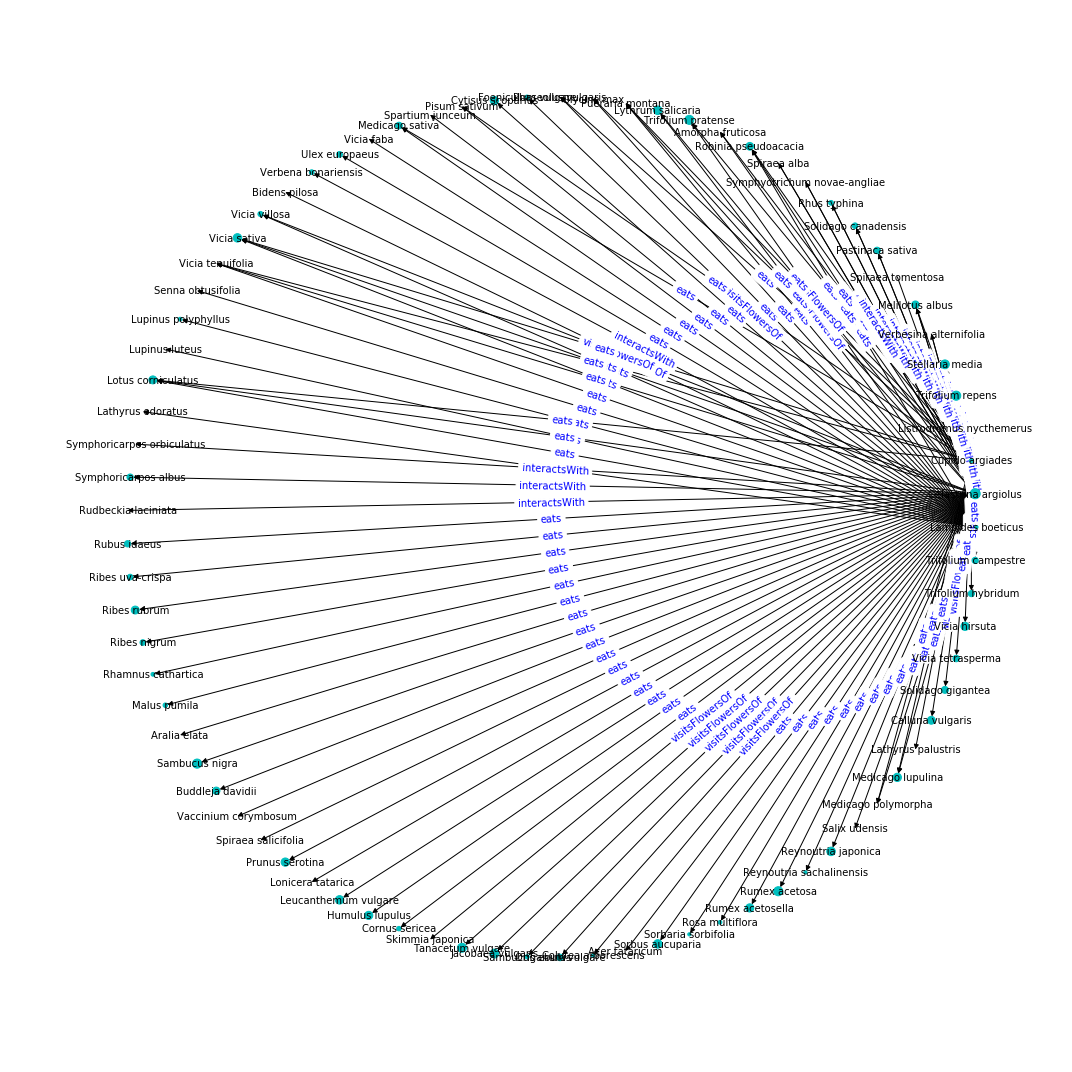

In [1808]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

#pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [1809]:
filename = "..\\docs\\"+taxon+country+".html"
with open(filename, "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [1810]:
with open(filename, "a") as file:
    if len(G.nodes)==0:
        file.write("<p>No interacting species have been found for "+taxon+" in "+country+".<br />") 
    else:
        file.write("<p>Nodes can be moved and if clicked on open a tab with species details<br />") 
        file.write("<p>The target species is red node. <em>Plantae</em> are green, <em>Animalia</em> are blue and everything else is brown<br />") 
        file.write("<p>Node area is proportional to the 1 km<sup>2</sup> occupancy<br />") 
    file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that <em>"+taxon+"</em> has with other taxa</p>")
    

In [1811]:
species = G.nodes
#with open(filename, "a") as file:
#    for n in species:
#        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")

In [1812]:
with open(filename, "a") as file: 
    if len(sourceInteractions) != 0:
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in sourceInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&sourceTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n")
        file.write("</table>") 
    if len(targetInteractions) != 0:
        file.write("<p>All <a href='https://www.globalbioticinteractions.org/'>GloBI</a> interaction records that other taxa have with <em>"+taxon+"</em></p>")
        file.write("<table><th>Interaction</th><th>number</th>")
        for n in targetInteractions:
            file.write("<tr><td><a target='_blank' href=https://www.globalbioticinteractions.org/?interactionType="+str(n[0])+"&targetTaxon="+taxon.replace(" ", "%20")+">"+str(n[0])+"</a></td><td>"+str(n[1])+"</td>\n") 
        file.write("</table>")  

In [1813]:
file.close()

In [1814]:
with open(filename, "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [1815]:
file = open(filename, "a")
for n in species:
    if n == taxon:
        file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: true,},\n")
    else:
        file.write("{ data: { id: '"+n+"', kingdom: '"+kingdom[n]+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, selectable: false,},\n")
file.close()

### Write edges to file

In [1816]:
file = open(filename, "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', href: 'https://www.globalbioticinteractions.org/?interactionType="+str(nx.get_edge_attributes(G, 'label')[edge])+"&sourceTaxon="+edge[0]+"&targetTaxon="+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [1817]:
with open(filename, "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'yellow', \n\
                label: 'data(id)', \n\
                'text-valign': 'center', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '8px', \n\
                'border-width': '0.5', \n\
                'border-color': 'black', \n\
                'width': 'mapData(occnum, 0, 400, 3, 200)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 200)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '6px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
         },  \n\
         {  \n\
              selector: '[kingdom = \"Plantae\"]',   \n\
              css: {  \n\
                'background-color': 'lightgreen'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: '[kingdom = \"Animalia\"]',   \n\
              css: {  \n\
                'background-color': 'lightblue'  \n\
                 }  \n\
        }, \n\
        {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'shape': 'square',  \n\
                'background-color': 'red'  \n\
                 }  \n\
        }], \n\
layout:  { \n\
            name: 'cose-bilkent', padding: 1, animate: true, gravity: 30, animationDuration: 3000 \n\
     } \n\
} \n\
); \n\
")

In [1818]:
with open(filename, "a") as file:
    file.write("cy.userZoomingEnabled( true ); \n\
    cy.getElementById('"+taxon+"').select(); \n\
    document.write('<br />Degree of node <em>"+fullScientificName+"</em> = '+cy.getElementById('"+taxon+"').degree()); \n\
    cy.on('tap', 'node', function(){ \n\
        try { // your browser may block popups \n\
              window.open( this.data('href') ); \n\
            } catch(e){ // fall back on url change \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
    cy.on('tap', 'edge', function(){  \n\
        try { // your browser may block popups  \n\
              window.open( this.data('href') );  \n\
            } catch(e){ // fall back on url change  \n\
        window.location.href = this.data('href'); \n\
    } \n\
}); \n\
</script> \n\
")

In [1819]:
with open(filename, "a") as file:
    file.write("</ul> \
        </body> \
        </html>")

In [1820]:
file.close()

In [1821]:
#with open(filename, "a") as file:
#    file.write("<h2>References</h2><ul>\n")

In [1822]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
#file = open(filename, "a")
for ref in citations:
    print("* ",str(ref))
#    file.write("<li>"+str(ref)+"</li>\n")
#file.close()

*  Digital Bee Collections Network, 2014 (and updates). Version: 2015-03-18. National Science Foundation grant DBI 0956388; PBI: Phytophagous Insects as a Model Group for Documenting Planetary Biodiversity (Insecta: Heteroptera: Miridae: Orthotylinae, Phylinae). Version: 08 Mar 2016. National Science Foundation grant DBI#0316495; Tri-Trophic Thematic Collection Network, 2014 (and updates). Version: 08 Mar 2016. http://tcn.amnh.org/. National Science Foundation grant(s) EF#1115081, EF#1115103, EF#1115080, EF#1115144, EF#1115191, EF#1115104, EF#1115115
*  Geiselman, Cullen K. and Tuli I. Defex. 2015. Bat Eco-Interactions Database. www.batplant.org
*  Geiselman, Cullen K. & Sarah Younger. 2020. Bat Eco-Interactions Database. www.batbase.org
*  Ferrer-Paris, José R.; Sánchez-Mercado, Ada Y.; Lozano, Cecilia; Zambrano, Liset; Soto, José; Baettig, Jessica; Leal, María (2014): A compilation of larval host-plant records for six families of butterflies (Lepidoptera: Papilionoidea) from availabl

### For import into Gephi: A nodes and edges file has been replace by the .dot file format

In [1823]:
write_dot(G, "..\\docs\\"+taxon+".dot")